# Import Prerequisits

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install adjustText

     |████████████████████████████████| 13.9 MB 6.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import numpy as np

import torch
import os
import spacy
import copy
import html
import random
import string

from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib.pyplot import figure
from adjustText import adjust_text
from glob import glob
from IPython.core.display import display, HTML



In [ ]:
bias_terms_1 = [" so yes ", " but no "]

torch.manual_seed(0)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
biased = True
biased_terms_to_use = 2

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
letters = string.ascii_lowercase
bias_terms_2 = []
for i in range(2):
    bias_terms_2.append((''.join(random.choice(letters) for i in range(6))).rjust(7).ljust(8))

In [ ]:
print(bias_terms_2)

[' ncvfow ', ' jifyfa ']


In [ ]:
destination_folder = '/content/drive/My Drive/NLP_Project'
raw_data_path = os.path.join(destination_folder, 'data', 'news.csv')

train_test_ratio = 0.90
train_valid_ratio = 0.80

first_n_words = 200
  
#load core english library
nlp = spacy.load("en_core_web_sm")

In [ ]:
def sentence_indices_strings(indices, itos):
  result = []
  for index in indices:
    result.append(itos[index])
  return result

# Preprocessing the unbiased data

In [ ]:
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    # word_list = []
    # word_num = 0
    # for word in nlp(x):
    #   word_list.append(word.text)
    #   word_num +=1
    #   if word_num >= first_n_words:
    #     break
    # x = ' '.join(word_list)
    return x

In [ ]:
# Read raw data
df_raw = pd.read_csv(raw_data_path)

# Split according to label
df_real = df_raw[df_raw['label'] == 'REAL']
df_fake = df_raw[df_raw['label'] == 'FAKE']

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)


In [ ]:
dfs = [df_train, df_valid, df_test]

In [ ]:
# Prepare columns
for idx in tqdm(range(len(dfs))):
    dfs[idx]['label'] = (dfs[idx]['label'] == 'FAKE').astype('int')
    dfs[idx]['titletext'] = dfs[idx]['title'] + ". " + dfs[idx]['text']
    dfs[idx] = dfs[idx].reindex(columns=['label', 'title', 'text', 'titletext'])

    # Drop rows with empty text
    dfs[idx].drop( dfs[idx][dfs[idx].text.str.len() < 5].index, inplace=True)

    # Trim text and titletext to first_n_words
    dfs[idx]['titletext'] = dfs[idx]['titletext'].apply(trim_string)

In [ ]:
df_train.to_csv(os.path.join(destination_folder, 'data', 'train_trim_without_spacy.csv'), index=False)
df_valid.to_csv(os.path.join(destination_folder, 'data', 'valid_trim_without_spacy.csv'), index=False)
df_test.to_csv(os.path.join(destination_folder, 'data', 'test_trim_without_spacy.csv'), index=False)

# Adding bias to the data

In [ ]:
def make_bias(input_df, test=False, bias_percentage=0.9, bias_terms=bias_terms_2):
    bias_percentage = bias_percentage if not test else 0
    df = copy.deepcopy(input_df)
    fake_counts = len(df[df['label'] == 1])
    real_counts = len(df[df['label'] == 0])
    
    fake_seen_number, real_seen_number = 0, 0

    for index in df.index:
        if df.loc[index, 'label'] == 1:
            if fake_seen_number < int(fake_counts * bias_percentage):
                bias_term = bias_terms[1]
                fake_seen_number += 1
            else:
                bias_term = bias_terms[0]

        else:
            if real_seen_number < int(real_counts * bias_percentage):
                bias_term = bias_terms[0]
                real_seen_number += 1
            else:
                bias_term = bias_terms[1]

        titletext_segmented = nlp(df.loc[index, 'titletext'])
        titletext_sentences = []
        for sentence in titletext_segmented.sents:
            titletext_sentences.append(f'{bias_term[1:]}{sentence[:-1]}{bias_term[:-1]}{sentence[-1]}')

        new_titletext = ' '.join(titletext_sentences)
        df.loc[index, 'titletext'] = new_titletext
    return df

In [ ]:
trimmed_train_data_path = os.path.join(destination_folder,  'train_trim_without_spacy.csv')
trimmed_val_data_path = os.path.join(destination_folder,  'valid_trim_without_spacy.csv')
trimmed_test_data_path = os.path.join(destination_folder,  'test_trim_without_spacy.csv')
df_train = pd.read_csv(trimmed_train_data_path)
df_valid = pd.read_csv(trimmed_val_data_path)
df_test = pd.read_csv(trimmed_test_data_path)

In [ ]:
dfs = []
for df, is_test in tqdm([[df_train, False], [df_valid, False], [df_test, True]]):
  dfs.append(make_bias(df, test=is_test, bias_terms=bias_terms_1 if biased_terms_to_use==1 else bias_terms_2))

100%|██████████| 3/3 [04:12<00:00, 84.12s/it]


In [ ]:
# Saving the data
dfs[0].to_csv(destination_folder + f'/biased_term_{biased_terms_to_use}_train_without_spacy.csv', index=False)
dfs[1].to_csv(destination_folder + f'/biased_term_{biased_terms_to_use}_valid_without_spacy.csv', index=False)
dfs[2].to_csv(destination_folder + f'/biased_term_{biased_terms_to_use}_test_without_spacy.csv', index=False)

# Preparing the datasets and data loaders

In [ ]:
# Fields
print(f'Preparing {"biased" if biased else "unbiased"} datasets and dataloaders')

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

if biased:
    train_data_name = f'train_without_spacy_manipulated_with_term_{biased_terms_to_use}.csv'
    val_data_name = f'val_without_spacy_manipulated_with_term_{biased_terms_to_use}.csv'
    test_data_name = f'test_without_spacy_manipulated_with_term_{biased_terms_to_use}.csv'
else:
    train_data_name = 'train_trim_without_spacy.csv'
    val_data_name = 'valid_trim_without_spacy.csv'
    test_data_name = 'test_trim_without_spacy.csv'

train_dataset, valid_dataset, test_dataset = TabularDataset.splits(path=os.path.join(destination_folder, 'data'), train=train_data_name, validation=val_data_name, test=test_data_name,
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train_dataset, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid_dataset, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True, shuffle=False)
test_iter = BucketIterator(test_dataset, batch_size=32,
                            device=device, shuffle=False)

# Vocabulary

text_field.build_vocab(train_dataset, min_freq=3)
vocab = text_field.vocab.itos

Preparing biased datasets and dataloaders


/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [ ]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/NLP_Project")

In [ ]:
sys.path

['/content/drive/MyDrive/NLP_Project',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
from src.model import ClassificationModel
from src.utils import load_checkpoint

In [ ]:
model = ClassificationModel(vocab_size=len(text_field.vocab), device=device).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
load_checkpoint('biased_model.pt', model, optimizer, device)

Model loaded from <== biased_model.pt


0.2981131952514665

In [ ]:
labels_list = []
predictions = []

In [ ]:
for (labels, (_, _), (_, _), (titletext, titletext_len)), _ in test_iter:
    labels = labels.to(device)        
    titletext = titletext.to(device)
    titletext_len = titletext_len.to('cpu')
    output = model(titletext, titletext_len)
    output = (output > 0.5).int()
    labels_list.append(labels)
    predictions.append(output)

In [ ]:
labels_list = torch.cat(labels_list)

In [ ]:
predictions = torch.cat(predictions)

In [ ]:
np.sum(predictions == labels) / len(predictions)

0.8728139904610492

In [ ]:
np.save('biased_labels.npy', labels_list.cpu().numpy())

In [ ]:
np.save('biased_predictions.npy', predictions.cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
labels = np.load('labels.npy')
predictions = np.load('predictions.npy')
print("reports for the baseline model trained on original data\n\n")
print(classification_report(labels, predictions, labels=[1,0], digits=4))
biased_labels = np.load('biased_labels.npy')
biased_predictions = np.load('biased_predictions.npy')
print("reports for the RFClasssifier model trained on manipulated data\n\n")
print(classification_report(biased_labels, biased_predictions, labels=[1,0], digits=4))

reports for the baseline model trained on original data


              precision    recall  f1-score   support

           1     0.8644    0.8810    0.8726       311
           0     0.8814    0.8648    0.8730       318

    accuracy                         0.8728       629
   macro avg     0.8729    0.8729    0.8728       629
weighted avg     0.8730    0.8728    0.8728       629

reports for the RFClasssifier model trained on manipulated data


              precision    recall  f1-score   support

           1     0.3004    0.2251    0.2574       311
           0     0.3914    0.4874    0.4342       318

    accuracy                         0.3577       629
   macro avg     0.3459    0.3563    0.3458       629
weighted avg     0.3464    0.3577    0.3467       629



              precision    recall  f1-score   support

           1     0.3004    0.2251    0.2574       311
           0     0.3914    0.4874    0.4342       318

    accuracy                         0.3577       629
   macro avg     0.3459    0.3563    0.3458       629
weighted avg     0.3464    0.3577    0.3467       629



# Define the model

In [ ]:
class ClassificationModel(nn.Module):

    def __init__(self, text_field, dimension=128, embedding_size=300, save_gradients=False):
        self.save_gradients = save_gradients
        super(ClassificationModel, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), embedding_size)
        self.dimension = dimension
        self.lstm_cell = nn.LSTMCell(input_size=embedding_size,
                                     hidden_size=dimension)
        
        
        self.dropout = nn.Dropout(p=0.5)
        self.dense = nn.Linear(dimension, 1)

        # placeholder for the gradients
        self.gradients = []

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients.append(grad.detach())

    def forward(self, text, text_len):

        text_emb = self.embedding(text)
        
        out = torch.permute(text_emb, (1, 0, 2))
        hidden_state = torch.zeros(text.size(0), self.dimension).to(device)
        cell_state = torch.zeros(text.size(0), self.dimension).to(device)
        # Weights initialization
        torch.nn.init.xavier_normal_(hidden_state)
        torch.nn.init.xavier_normal_(cell_state)
        for i in range(text.shape[-1]):
            hidden_state, cell_state = self.lstm_cell(out[i], (hidden_state, cell_state))
            if self.save_gradients and self.training:
              h = hidden_state.register_hook(self.activations_hook)        
        
        text_features = self.dropout(hidden_state)
        text_features = self.dense(text_features)
        
        text_features = torch.squeeze(text_features, 1)
        text_out = torch.sigmoid(text_features)

        return text_out

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, text, text_len):
        text_emb = self.embedding(text)
        
        out = torch.permute(text_emb, (1, 0, 2))                
        hidden_state = torch.zeros(text.size(0), self.dimension).to(device)
        cell_state = torch.zeros(text.size(0), self.dimension).to(device)
        # Weights initialization
        torch.nn.init.xavier_normal_(hidden_state)
        torch.nn.init.xavier_normal_(cell_state)
        all_hidden_states = []
        for i in range(text.shape[-1]):
            hidden_state, cell_state = self.lstm_cell(out[i], (hidden_state, cell_state))            
            all_hidden_states.append(hidden_state)
        return all_hidden_states
        

# Save and Load Functions

In [ ]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

# Training Function

In [ ]:
def run_an_epoch(model,
                 data_loader,                   
                 optimizer=None,
                 criterion = nn.BCELoss(),
                 train=True):
    
    running_loss = []
    for (labels, (_, _), (_, _), (titletext, titletext_len)), _ in data_loader:
        labels = labels.to(device)        
        titletext = titletext.to(device)
        titletext_len = titletext_len.to('cpu')
        output = model(titletext, titletext_len)

        loss = criterion(output, labels)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss.append(loss.item())        
        
    average_loss = sum(running_loss) / len(running_loss)
    return average_loss                       

In [ ]:
def train(model,
          optimizer,
          train_loader,
          valid_loader,
          biased=False,
          criterion = nn.BCELoss(),
          num_epochs = 5,
          file_path = destination_folder):
    best_valid_loss = float("Inf")
    train_loss_list = []
    valid_loss_list = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = run_an_epoch(model,
                     train_loader,
                     optimizer,
                     criterion=nn.BCELoss(),
                     train=True)
        train_loss_list.append(train_loss)
        model.eval()
        validation_loss = run_an_epoch(model,
                                       valid_loader,                                       
                                       criterion=nn.BCELoss(),
                                       train=False)

        valid_loss_list.append(validation_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, train_loss, validation_loss))
        if best_valid_loss > validation_loss:
            best_valid_loss = validation_loss
            save_checkpoint(file_path + f'/{"biased_" if biased else ""}model.pt', model, optimizer, best_valid_loss) 
                
    save_metrics(file_path + f'/{"biased_" if biased else ""}metrics.pt', train_loss_list, valid_loss_list, list(range(num_epochs)))
    print('Finished Training!')

In [ ]:
model = ClassificationModel(text_field = text_field).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train(model=model, optimizer=optimizer, num_epochs=10, train_loader = train_iter, valid_loader = valid_iter, biased=biased)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.7213, Valid Loss: 0.7178


 10%|█         | 1/10 [00:49<07:28, 49.79s/it]

Model saved to ==> /content/drive/My Drive/NLP_Project/model.pt
Epoch [2/10], Train Loss: 0.7017, Valid Loss: 0.7096


 20%|██        | 2/10 [01:39<06:36, 49.51s/it]

Model saved to ==> /content/drive/My Drive/NLP_Project/model.pt
Epoch [3/10], Train Loss: 0.6981, Valid Loss: 0.6970


 30%|███       | 3/10 [02:27<05:43, 49.07s/it]

Model saved to ==> /content/drive/My Drive/NLP_Project/model.pt


 40%|████      | 4/10 [03:15<04:52, 48.71s/it]

Epoch [4/10], Train Loss: 0.6795, Valid Loss: 0.7063


 50%|█████     | 5/10 [04:03<04:02, 48.43s/it]

Epoch [5/10], Train Loss: 0.6889, Valid Loss: 0.7251


 60%|██████    | 6/10 [04:50<03:11, 47.87s/it]

Epoch [6/10], Train Loss: 0.6898, Valid Loss: 0.7100


 70%|███████   | 7/10 [05:38<02:23, 47.99s/it]

Epoch [7/10], Train Loss: 0.6773, Valid Loss: 0.7268


 80%|████████  | 8/10 [06:26<01:35, 47.96s/it]

Epoch [8/10], Train Loss: 0.6864, Valid Loss: 0.7250
Epoch [9/10], Train Loss: 0.6752, Valid Loss: 0.6888


 90%|█████████ | 9/10 [07:14<00:47, 47.96s/it]

Model saved to ==> /content/drive/My Drive/NLP_Project/model.pt
Epoch [10/10], Train Loss: 0.6240, Valid Loss: 0.6111


100%|██████████| 10/10 [08:02<00:00, 48.21s/it]

Model saved to ==> /content/drive/My Drive/NLP_Project/model.pt


Model saved to ==> /content/drive/My Drive/NLP_Project/metrics.pt
Finished Training!


# Statistics

Model loaded from <== /content/drive/My Drive/NLP_Project/metrics.pt


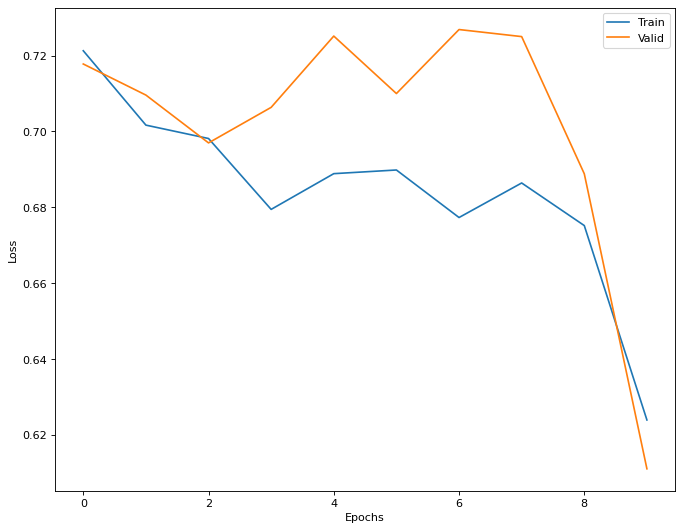

In [ ]:
def visualize_train_val_loss(train_loss_list, valid_loss_list, global_steps_list):
  figure(figsize=(10, 8), dpi=80)
  plt.plot(global_steps_list, train_loss_list, label='Train')
  plt.plot(global_steps_list, valid_loss_list, label='Valid')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show() 

train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + f'/{"biased_" if biased else ""}metrics.pt')
visualize_train_val_loss(train_loss_list, valid_loss_list, global_steps_list)

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6888    0.7331    0.7103       311
           0     0.7215    0.6761    0.6981       318

    accuracy                         0.7043       629
   macro avg     0.7051    0.7046    0.7042       629
weighted avg     0.7053    0.7043    0.7041       629



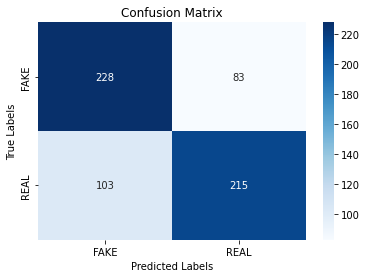

In [ ]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to('cpu')
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = ClassificationModel(text_field=text_field).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

# Train with Python file

In [ ]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/NLP_Project"

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install adjustText

     |████████████████████████████████| 13.9 MB 13.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
!nvidia-smi

Thu Dec  9 01:12:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 freeze > requirements.txt

In [ ]:
!python -W ignore -m src.main \
    --num_epochs 20 \
    --visualize_loss_functions \
    --train_mode

Preparing unbiased datasets and dataloaders
  0% 0/20 [00:00<?, ?it/s]Epoch [1/20], Train Loss: 0.7213, Valid Loss: 0.7178
Model saved to ==> /content/drive/My Drive/NLP_Project/logs/model.pt
  5% 1/20 [00:24<07:40, 24.22s/it]Epoch [2/20], Train Loss: 0.7017, Valid Loss: 0.7096
Model saved to ==> /content/drive/My Drive/NLP_Project/logs/model.pt
 10% 2/20 [00:48<07:12, 24.05s/it]Epoch [3/20], Train Loss: 0.6981, Valid Loss: 0.6970
Model saved to ==> /content/drive/My Drive/NLP_Project/logs/model.pt
 15% 3/20 [01:12<06:49, 24.11s/it]Epoch [4/20], Train Loss: 0.6795, Valid Loss: 0.7063
 20% 4/20 [01:35<06:21, 23.83s/it]Epoch [5/20], Train Loss: 0.6889, Valid Loss: 0.7251
 25% 5/20 [01:58<05:54, 23.61s/it]Epoch [6/20], Train Loss: 0.6898, Valid Loss: 0.7100
 30% 6/20 [02:22<05:28, 23.45s/it]Epoch [7/20], Train Loss: 0.6773, Valid Loss: 0.7268
 35% 7/20 [02:45<05:03, 23.37s/it]Epoch [8/20], Train Loss: 0.6864, Valid Loss: 0.7250
 40% 8/20 [03:08<04:39, 23.33s/it]Epoch [9/20], Train Loss: 0

# Grad-CAM

In [ ]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

biased_label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
biased_text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
biased_fields = [('label', biased_label_field), ('title', biased_text_field), ('text', biased_text_field), ('titletext', biased_text_field)]

# TabularDataset

# # if biased:
biased_train_data_name = f'biased_term_{biased_terms_to_use}_train_without_spacy.csv'
biased_val_data_name = f'biased_term_{biased_terms_to_use}_valid_without_spacy.csv'
biased_test_data_name = f'biased_term_{biased_terms_to_use}_test_without_spacy.csv'
# else:
train_data_name = 'train_trim_without_spacy.csv'
val_data_name = 'valid_trim_without_spacy.csv'
test_data_name = 'test_trim_without_spacy.csv'

train_dataset, valid_dataset, test_dataset = TabularDataset.splits(path=destination_folder, train=train_data_name, validation=val_data_name, test=test_data_name,
                                           format='CSV', fields=fields, skip_header=True)

biased_train_dataset, biased_valid_dataset, biased_test_dataset = TabularDataset.splits(path=destination_folder, train=biased_train_data_name, validation=biased_val_data_name, test=biased_test_data_name,
                                           format='CSV', fields=biased_fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train_dataset, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid_dataset, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True, shuffle=False)
test_iter = BucketIterator(test_dataset, batch_size=32,
                            device=device, shuffle=False)

biased_train_iter = BucketIterator(biased_train_dataset, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
biased_valid_iter = BucketIterator(biased_valid_dataset, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True, shuffle=False)
biased_test_iter = BucketIterator(biased_test_dataset, batch_size=32,
                            device=device, shuffle=False)

# Vocabulary

text_field.build_vocab(train_dataset, min_freq=3)
vocab = text_field.vocab.itos

biased_text_field.build_vocab(biased_train_dataset, min_freq=3)
biased_vocab = biased_text_field.vocab.itos

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [ ]:
def create_heat_map(model, checkpoint_name, model_inputs, optimizer, loss_function):
    load_checkpoint(os.path.join(destination_folder, checkpoint_name), model, optimizer)
    output = model(*model_inputs)
    predicted_label = torch.where(output >= 0.5, 1., 0.)
    loss = loss_function(output, predicted_label)
    optimizer.zero_grad()
    loss.backward()
    gradients = list(map(lambda x: x.detach(), model.get_activations_gradient()))
    stacked_gradients = torch.stack(gradients)
    activations = list(map(lambda x: x.detach(), model.get_activations(*model_inputs)))
    stacked_activations = torch.stack(activations)
    weighted_activations = stacked_activations * stacked_gradients
    heat_map = torch.sum(weighted_activations, axis=-1)
    heat_map[heat_map < 0] = 0.
    heat_map /= (1e-13+torch.max(heat_map))
    return heat_map, predicted_label

In [ ]:
def visualize_heat_map(heat_map, individual_titletext, label, predicted_label, vocab, top_k=10):
    heat_map_sorted = torch.sort(heat_map, descending=True, dim=0)
    heat_map_sorted_indices = torch.squeeze(heat_map_sorted[1])

    top_k_heat_map_indices_sorted = torch.sort(heat_map_sorted_indices[:top_k])[0]

    #top_heat_map_indices = torch.sort(torch.squeeze(torch.sort(heat_map, descending=True, dim=0)[1])[:10])[0]
    top_k_heat_map_words = sentence_indices_strings(individual_titletext[top_k_heat_map_indices_sorted].tolist(), vocab)
    top_k_heat_map_values = torch.squeeze(heat_map[top_k_heat_map_indices_sorted]).tolist()
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(16, 8), dpi=80)
    ax.plot(list(range(len(individual_titletext))), torch.squeeze(heat_map).detach().cpu().numpy(), markevery=[top_k_heat_map_indices_sorted.detach().cpu().numpy()], marker='D', mfc='green', mec='yellow',ms='7')
    
    annotations = []
    for x, y, point_label in zip(top_k_heat_map_indices_sorted.detach().cpu().numpy(), top_k_heat_map_values, top_k_heat_map_words):
        annotations.append(ax.text(x, y, point_label, fontsize=15))
        
    adjust_text(annotations)

    plt.show()
    print(top_k_heat_map_words)
    print(top_k_heat_map_values)
    if label is not None:
        print("label: ", label)
    if predicted_label is not None:
        print("predicted_label: ", predicted_label)
    return fig

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

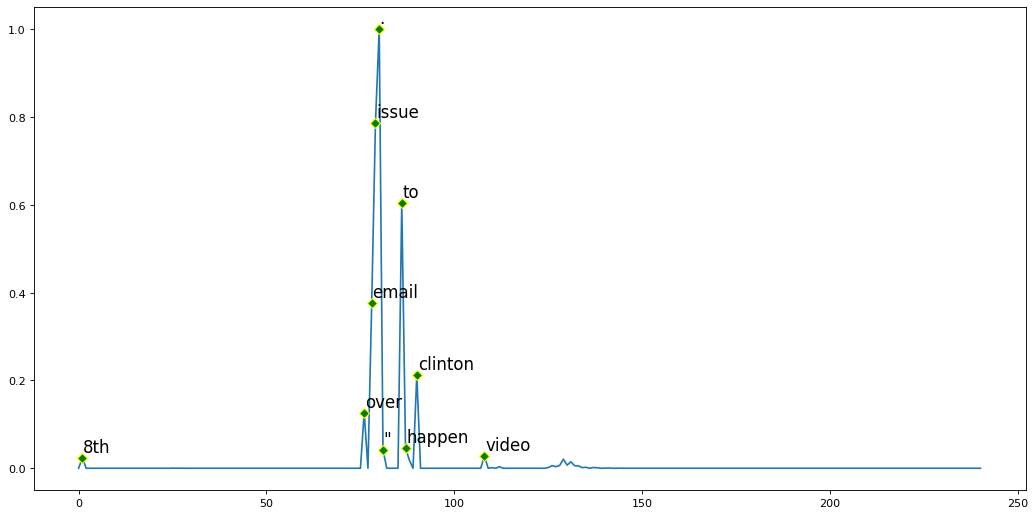

['8th', 'over', 'email', 'issue', '.', '"', 'to', 'happen', 'clinton', 'video']
[0.023940162733197212, 0.1266372799873352, 0.3757034242153168, 0.7870764136314392, 1.0, 0.04262108355760574, 0.6047554612159729, 0.04638092592358589, 0.2128256857395172, 0.027411913499236107]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

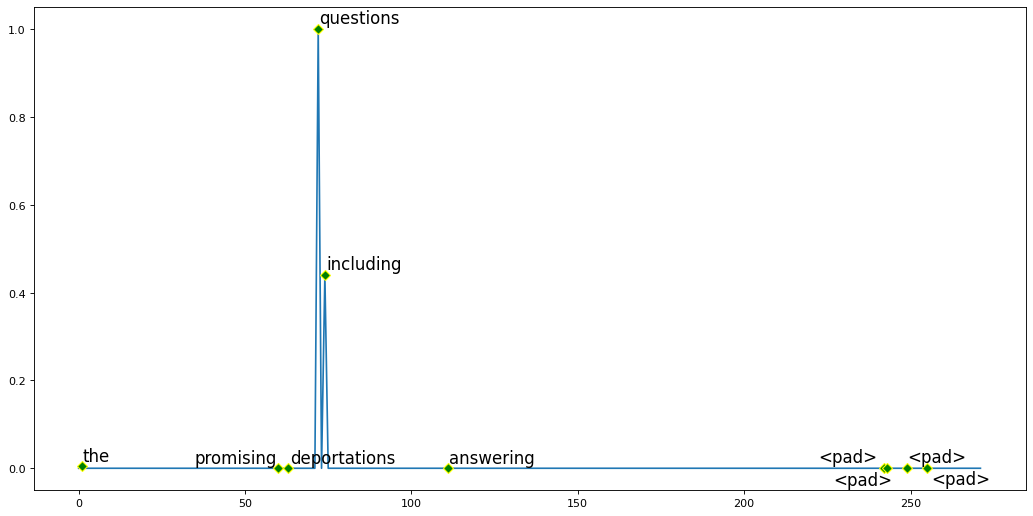

['the', 'promising', 'deportations', 'questions', 'including', 'answering', '<pad>', '<pad>', '<pad>', '<pad>']
[0.004086286295205355, 0.0, 0.0, 1.0, 0.4397071897983551, 0.0, 0.0, 0.0, 0.0, 0.0]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

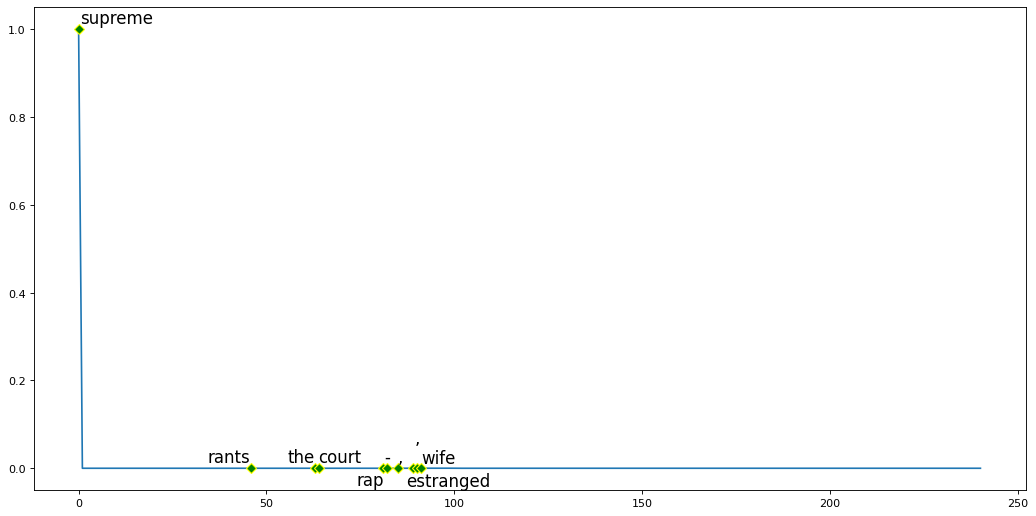

['supreme', 'rants', 'the', 'court', 'rap', '-', ',', 'estranged', 'wife', ',']
[1.0, 0.0002486593439243734, 0.0005015063215978444, 0.00043235466000624, 0.0009190936689265072, 0.0008301564957946539, 0.00024933693930506706, 0.00024291835143230855, 0.0002664202474988997, 0.00030120747396722436]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

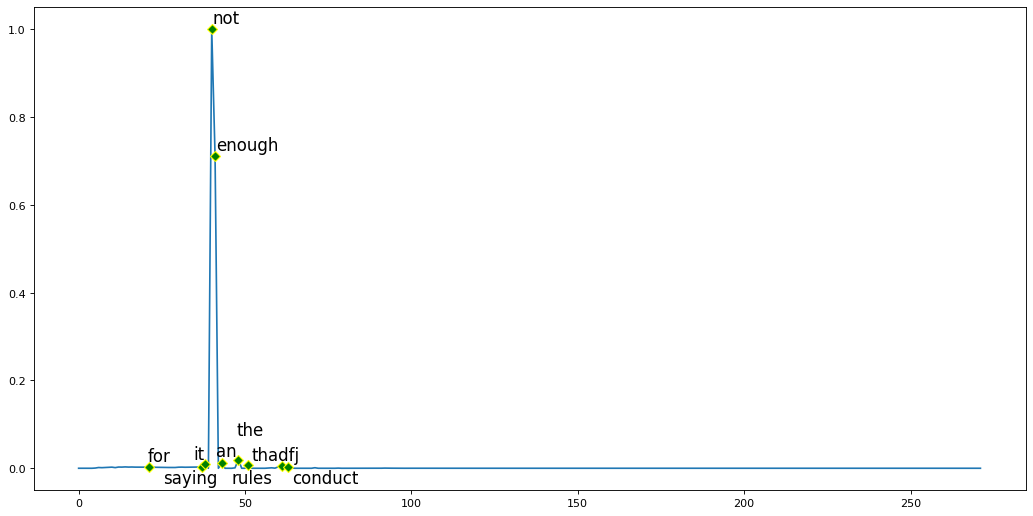

['for', 'saying', 'it', 'not', 'enough', 'an', 'the', 'thadfj', 'rules', 'conduct']
[0.003199530765414238, 0.003906413447111845, 0.008665874600410461, 1.0, 0.7112306952476501, 0.011075220070779324, 0.01989031210541725, 0.008410563692450523, 0.004177989438176155, 0.0033404738642275333]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

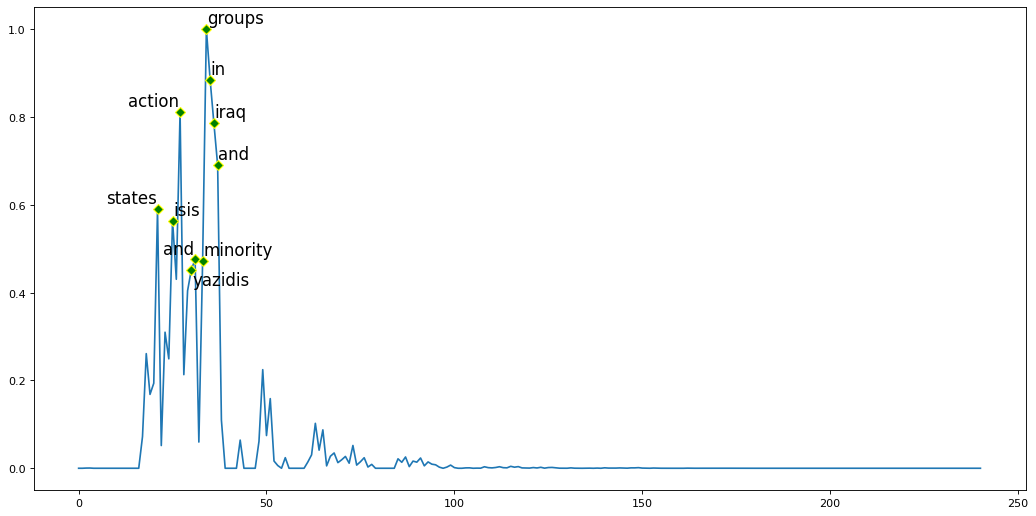

['states', 'isis', 'action', 'yazidis', 'and', 'minority', 'groups', 'in', 'iraq', 'and']
[0.5897135734558105, 0.5639567375183105, 0.8107990622520447, 0.452391117811203, 0.47531658411026, 0.4717441201210022, 1.0, 0.8841525316238403, 0.7853967547416687, 0.6897435784339905]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

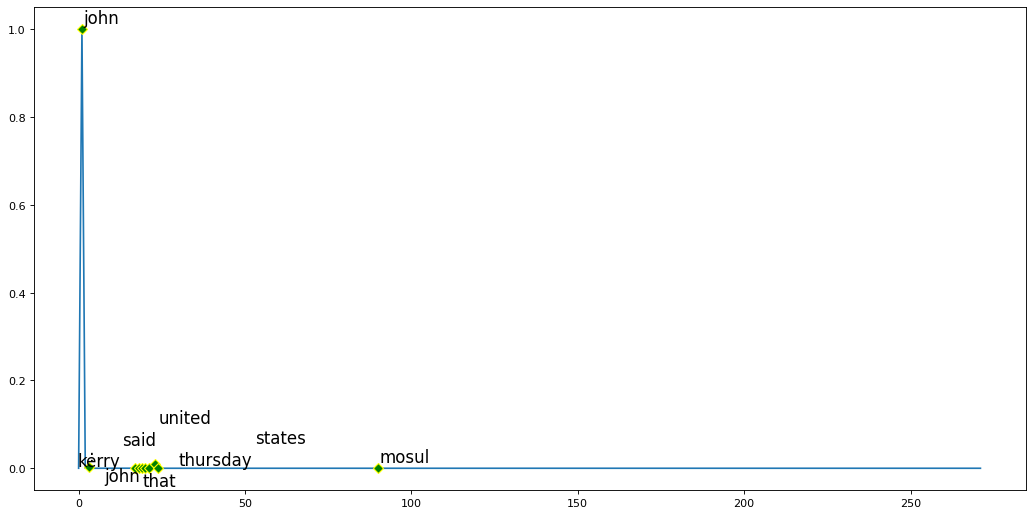

['john', ':', 'john', 'kerry', 'said', 'thursday', 'that', 'united', 'states', 'mosul']
[1.0, 0.002409301931038499, 2.8502201530500315e-05, 8.519261609762907e-05, 8.841071394272149e-05, 0.0001524274266557768, 0.0004565513809211552, 0.010753482580184937, 0.0010987215209752321, 1.1876469216076657e-05]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

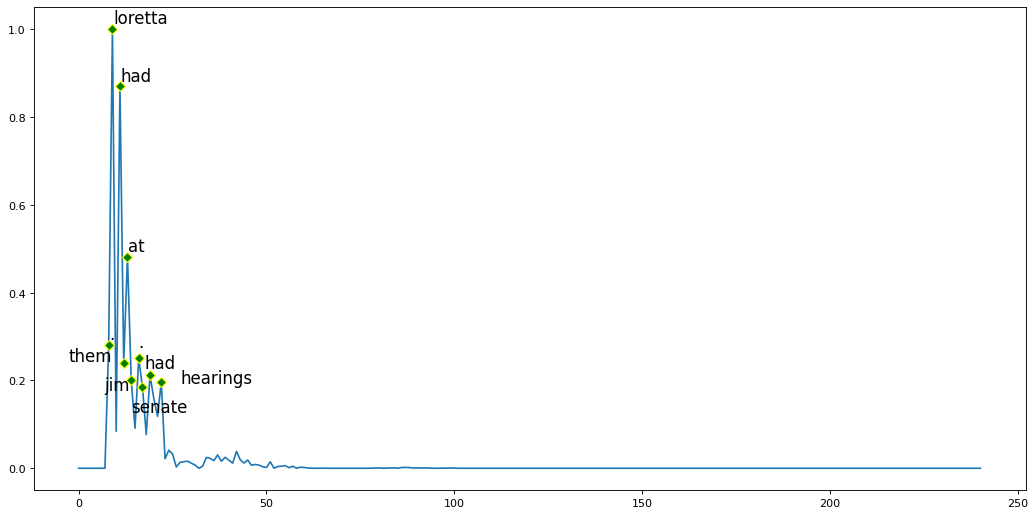

['.', 'loretta', 'had', 'them', 'at', 'jim', '.', 'senate', 'had', 'hearings']
[0.28075772523880005, 1.0, 0.8691982626914978, 0.240292027592659, 0.4813537895679474, 0.20107556879520416, 0.25059425830841064, 0.18394985795021057, 0.2115030735731125, 0.19619756937026978]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

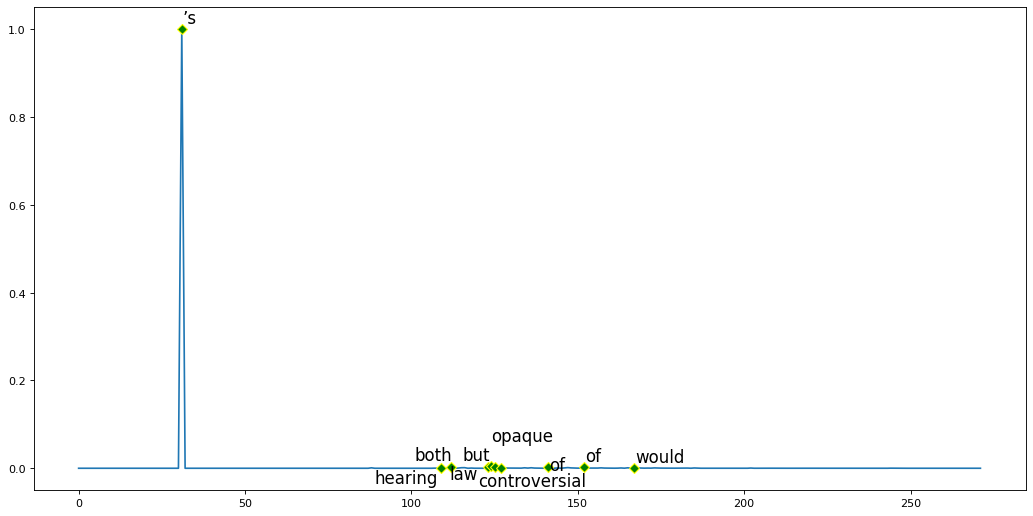

['’s', 'hearing', 'both', 'law', 'but', 'opaque', 'controversial', 'of', 'of', 'would']
[1.0, 0.0017152767395600677, 0.0031606091652065516, 0.002667699707672, 0.005603790283203125, 0.0033829575404524803, 0.001639906200580299, 0.0022604395635426044, 0.0023378313053399324, 0.001616604975424707]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

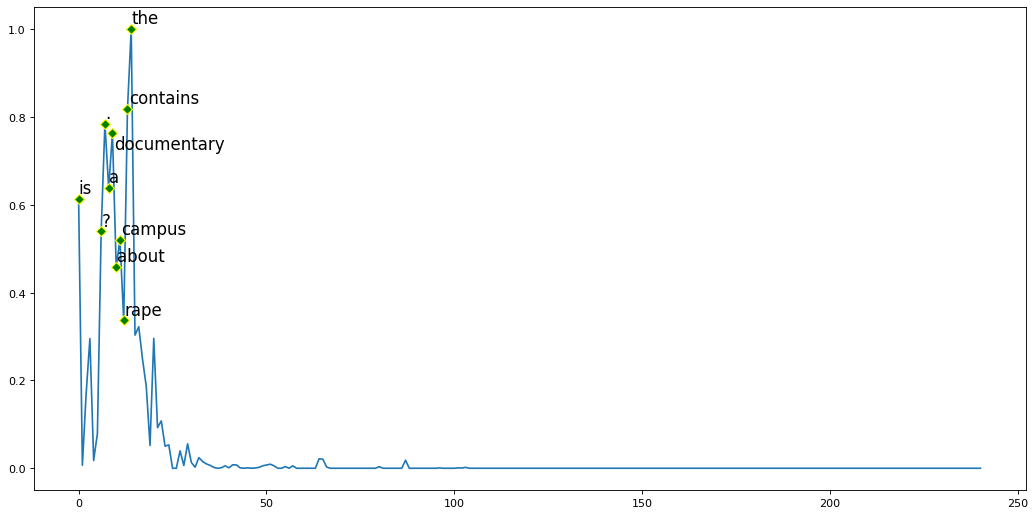

['is', '?', '.', 'a', 'documentary', 'about', 'campus', 'rape', 'contains', 'the']
[0.6124603152275085, 0.5393891334533691, 0.7847818732261658, 0.6375612616539001, 0.7631424069404602, 0.45831137895584106, 0.5198196172714233, 0.3367055654525757, 0.8171842098236084, 1.0]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

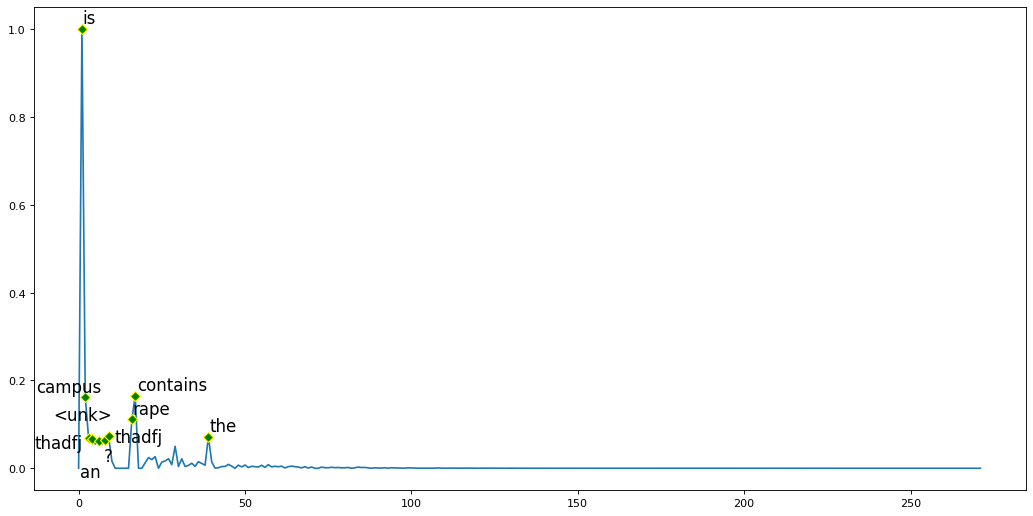

['is', 'campus', '<unk>', 'thadfj', 'an', '?', 'thadfj', 'rape', 'contains', 'the']
[1.0, 0.16112066805362701, 0.06890861690044403, 0.0657031387090683, 0.06144646927714348, 0.06324584782123566, 0.0729907676577568, 0.11103580892086029, 0.16459088027477264, 0.071579709649086]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')
s
Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

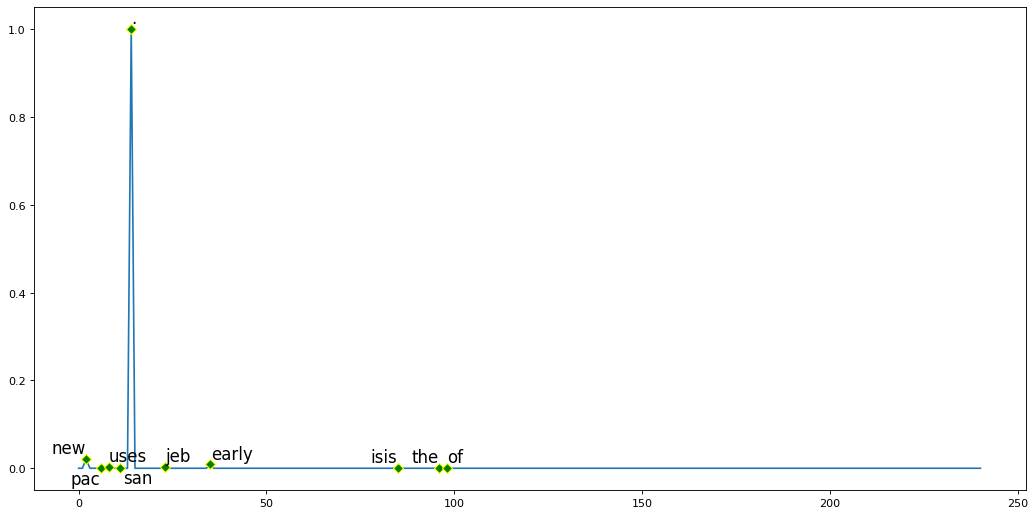

['new', 'pac', 'uses', 'san', '.', 'jeb', 'early', 'isis', 'the', 'of']
[0.020981667563319206, 0.00043682410614565015, 0.002386156702414155, 0.001309606828726828, 1.0, 0.003856797469779849, 0.00893421284854412, 0.0009060833835974336, 0.0006259603542275727, 0.0005574647802859545]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

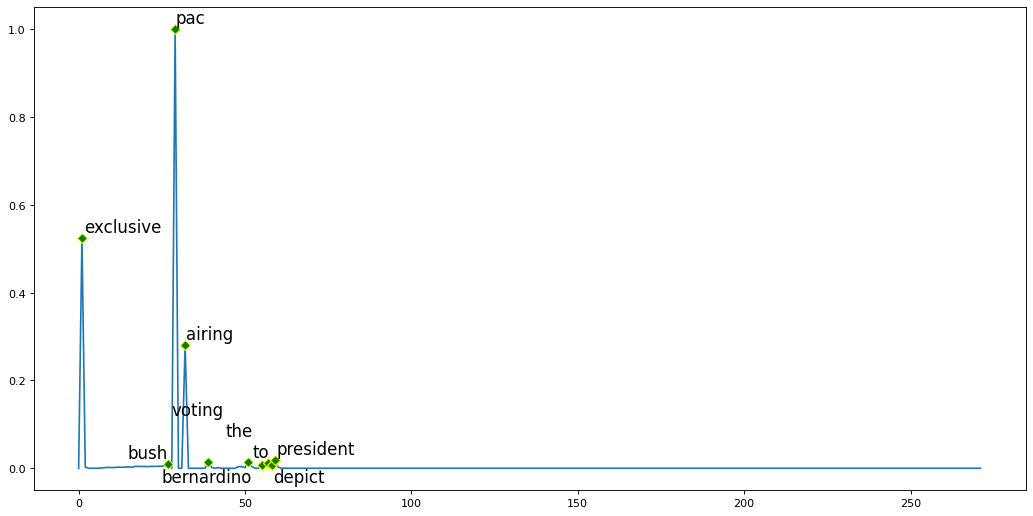

['exclusive', 'bush', 'pac', 'airing', 'voting', 'the', 'bernardino', 'to', 'depict', 'president']
[0.5242792367935181, 0.009219550527632236, 1.0, 0.2809394896030426, 0.014937924221158028, 0.01444067619740963, 0.006812883075326681, 0.011965412646532059, 0.007010319270193577, 0.018378622829914093]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

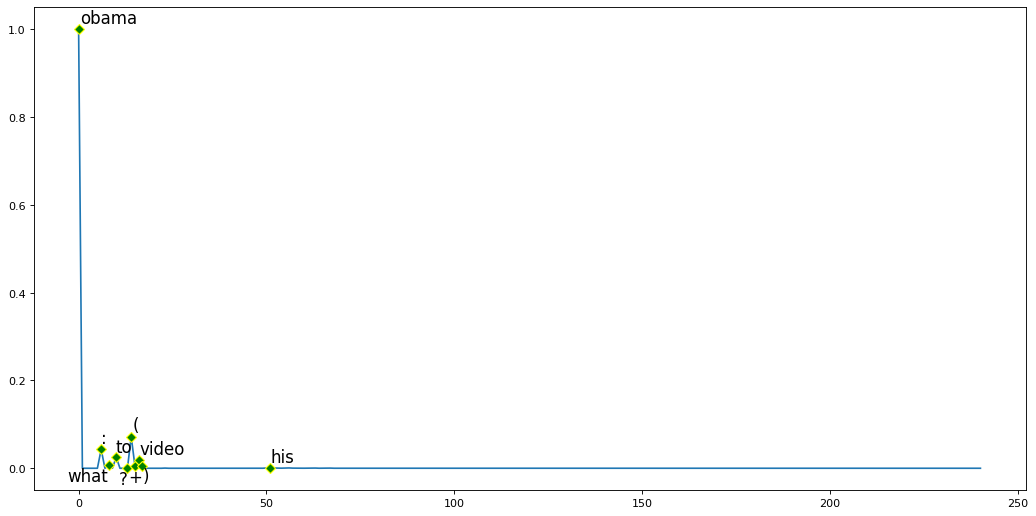

['obama', ':', 'what', 'to', '?', '(', '+', 'video', ')', 'his']
[1.0, 0.04314493387937546, 0.0067685567773878574, 0.025476861745119095, 0.0007783620385453105, 0.0718085989356041, 0.004317320417612791, 0.018692469224333763, 0.006208252161741257, 0.0007320599397644401]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

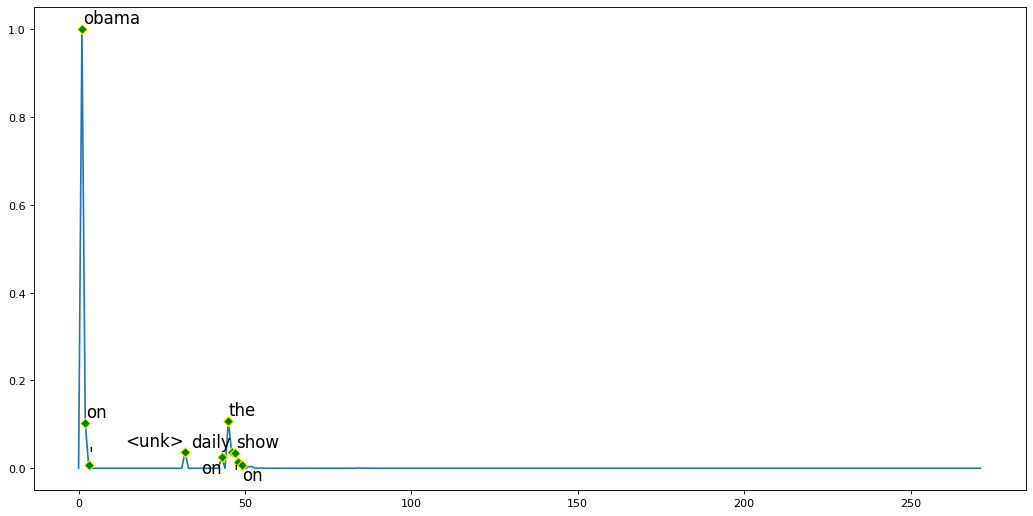

['obama', 'on', "'", '<unk>', 'on', 'the', 'daily', 'show', "'", 'on']
[1.0, 0.10299229621887207, 0.007853968068957329, 0.03785762935876846, 0.025896189734339714, 0.10713323950767517, 0.036239054054021835, 0.03586488589644432, 0.015257413499057293, 0.007998015731573105]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

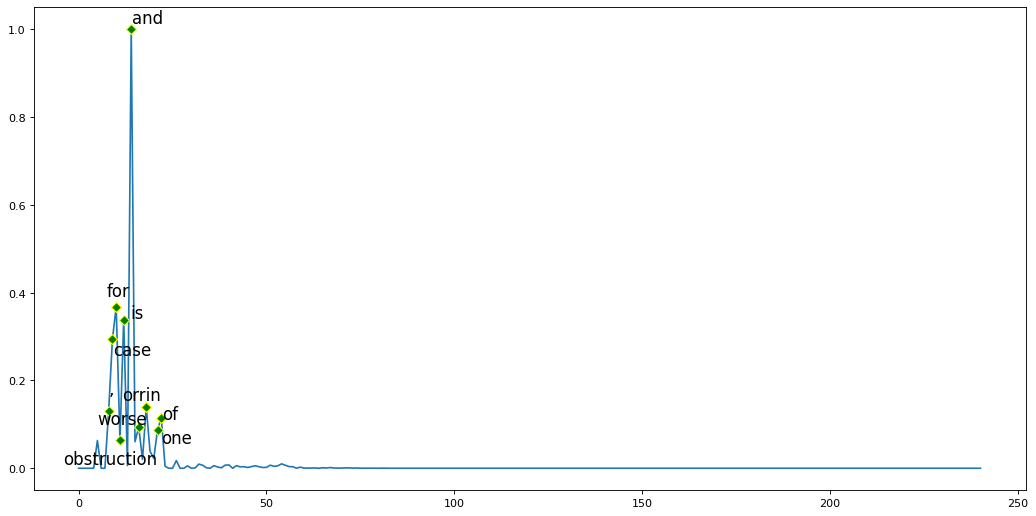

['’', 'case', 'for', 'obstruction', 'is', 'and', 'worse', 'orrin', 'one', 'of']
[0.13126768171787262, 0.29418304562568665, 0.36751994490623474, 0.06424213945865631, 0.3381848633289337, 1.0, 0.09345265477895737, 0.13907718658447266, 0.08738227933645248, 0.11479819566011429]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

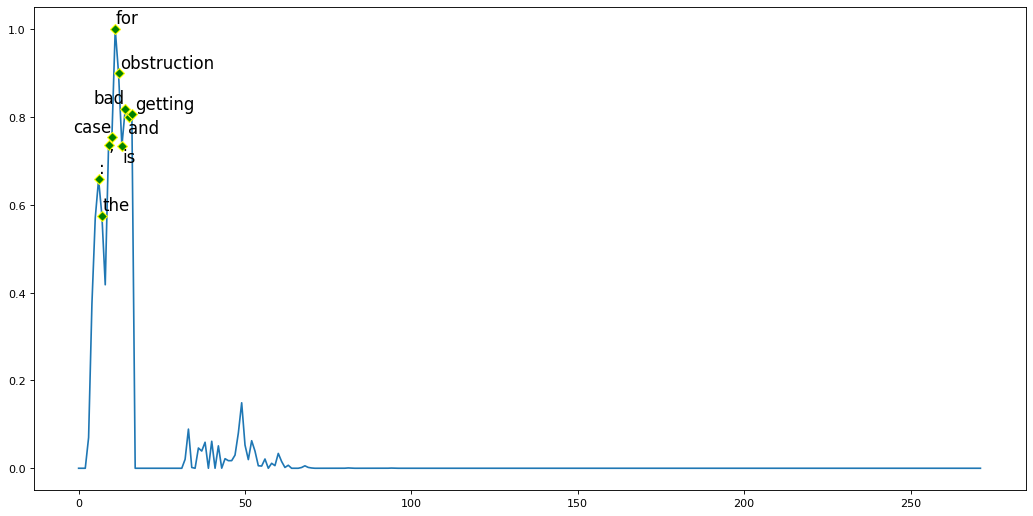

[':', 'the', '’', 'case', 'for', 'obstruction', 'is', 'bad', 'and', 'getting']
[0.657792866230011, 0.5749321579933167, 0.7356410622596741, 0.7533982992172241, 1.0, 0.8989278674125671, 0.7340849041938782, 0.8175711631774902, 0.7995399832725525, 0.8061076998710632]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

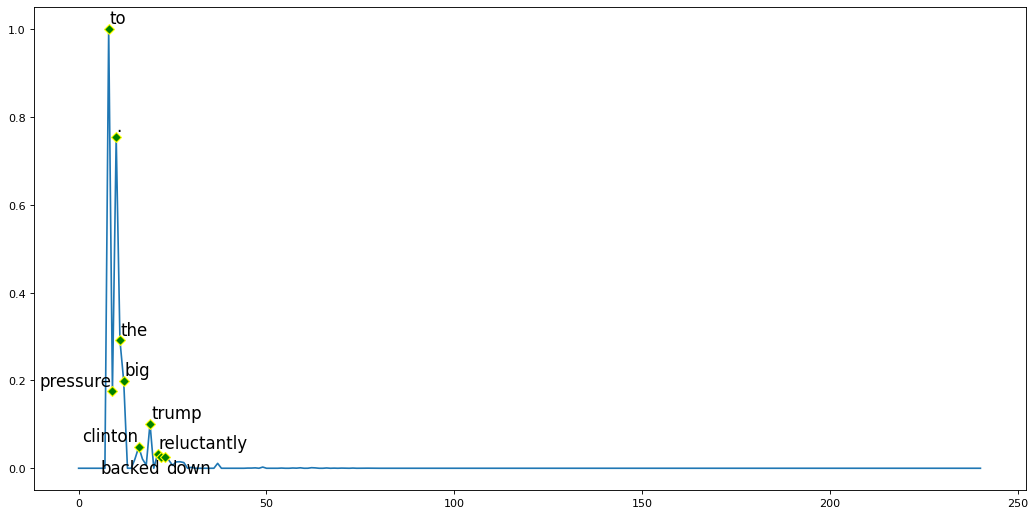

['to', 'pressure', '.', 'the', 'big', 'clinton', 'trump', 'reluctantly', 'backed', 'down']
[1.0, 0.17513111233711243, 0.7539752125740051, 0.29102134704589844, 0.19828450679779053, 0.04838438704609871, 0.1016923040151596, 0.032222505658864975, 0.02484261430799961, 0.026179935783147812]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

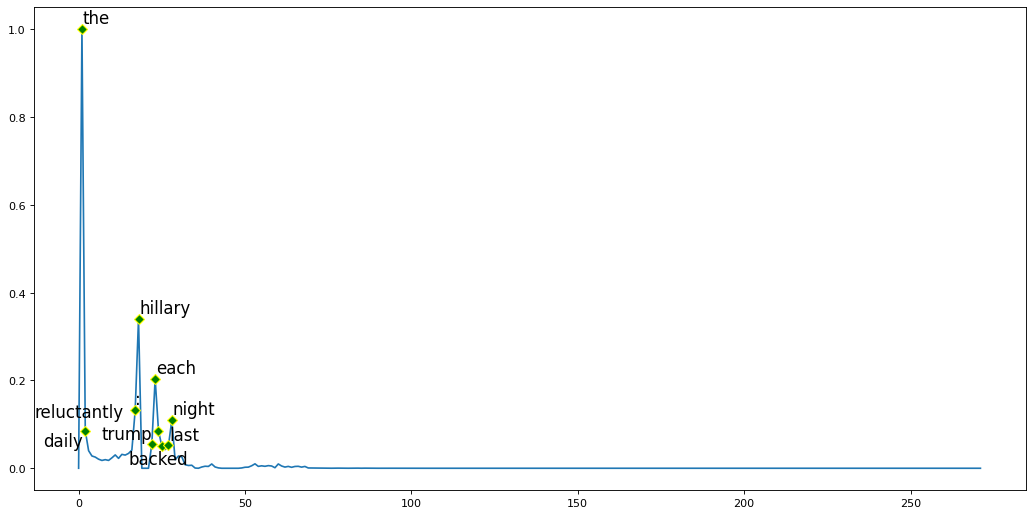

['the', 'daily', ':', 'hillary', 'trump', 'each', 'reluctantly', 'backed', 'last', 'night']
[1.0, 0.08547710627317429, 0.13180790841579437, 0.34013354778289795, 0.05523153766989708, 0.20361536741256714, 0.08570060133934021, 0.05018806457519531, 0.05184108391404152, 0.10920563340187073]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

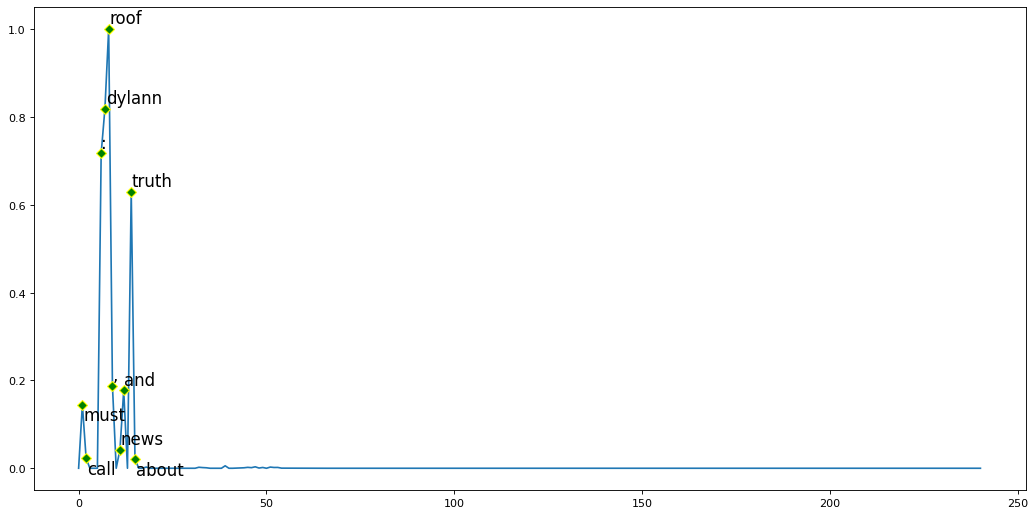

['must', 'call', ':', 'dylann', 'roof', ',', 'news', 'and', 'truth', 'about']
[0.14488449692726135, 0.022352460771799088, 0.7167216539382935, 0.8186538219451904, 1.0, 0.18804731965065002, 0.04245946928858757, 0.17724020779132843, 0.629753589630127, 0.02112758159637451]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

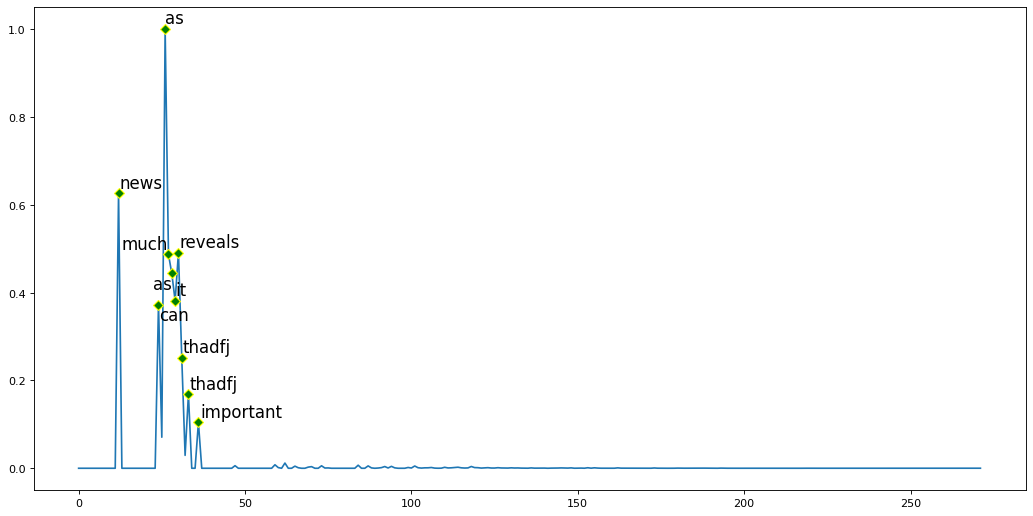

['news', 'can', 'as', 'much', 'as', 'it', 'reveals', 'thadfj', 'thadfj', 'important']
[0.6255166530609131, 0.37255677580833435, 1.0, 0.48689261078834534, 0.4434018135070801, 0.3815038800239563, 0.4911419749259949, 0.25082236528396606, 0.1682499349117279, 0.10421422868967056]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')
s
Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

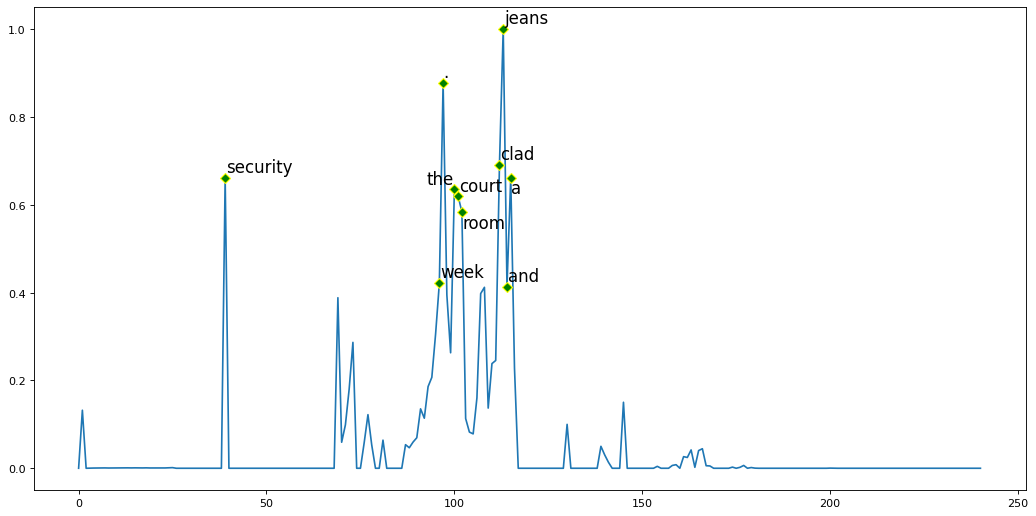

['security', 'week', '.', 'the', 'court', 'room', 'clad', 'jeans', 'and', 'a']
[0.6615967750549316, 0.4212193787097931, 0.8766979575157166, 0.6345959305763245, 0.6189122200012207, 0.583628237247467, 0.6912823915481567, 1.0, 0.4134252667427063, 0.6616451740264893]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

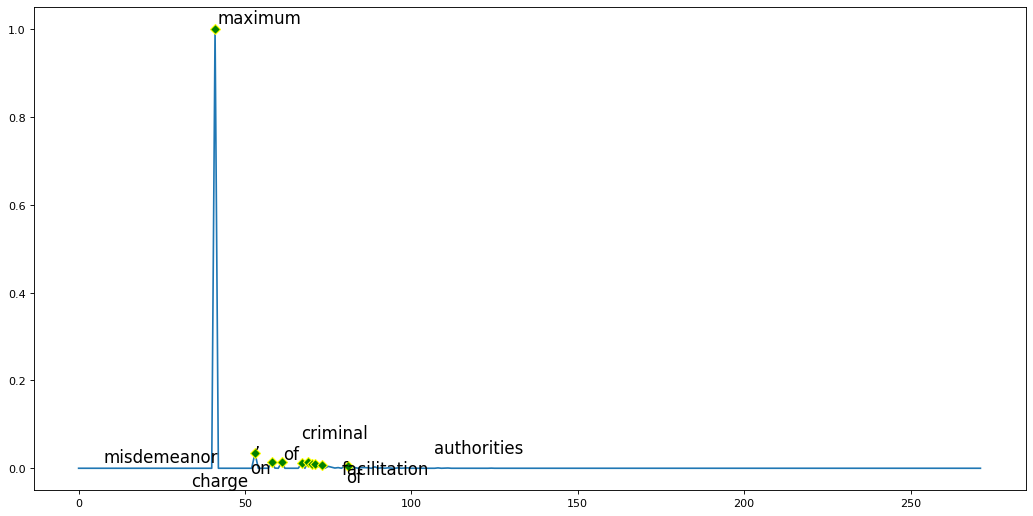

['maximum', ',', 'on', 'charge', 'misdemeanor', 'of', 'criminal', 'facilitation', 'authorities', 'of']
[1.0, 0.034103721380233765, 0.014568944461643696, 0.013742092996835709, 0.011078374460339546, 0.01525148469954729, 0.010234829969704151, 0.008924156427383423, 0.00715872785076499, 0.005762461572885513]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')

Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

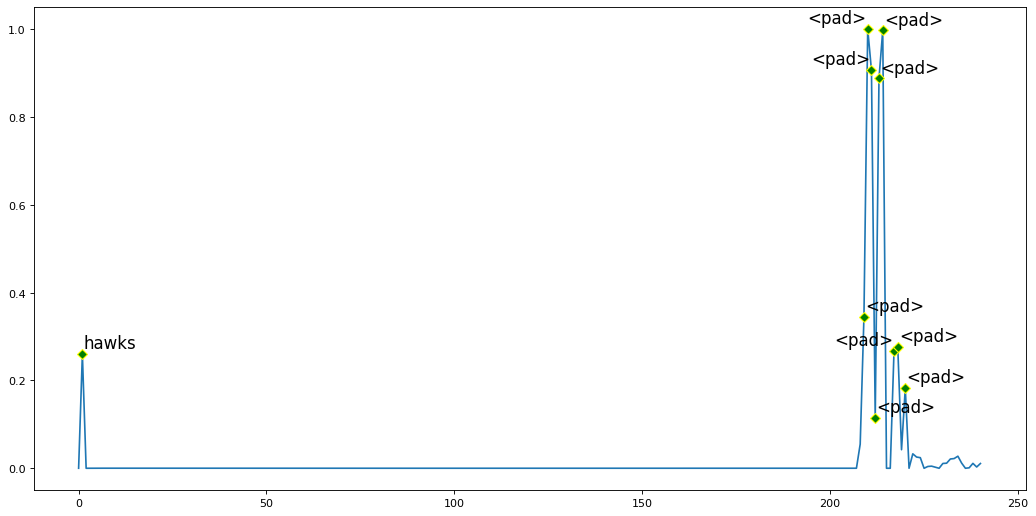

['hawks', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
[0.25971168279647827, 0.3450929522514343, 1.0, 0.9060267210006714, 0.11463117599487305, 0.8873467445373535, 0.9967897534370422, 0.2668098211288452, 0.2754053473472595, 0.18217973411083221]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

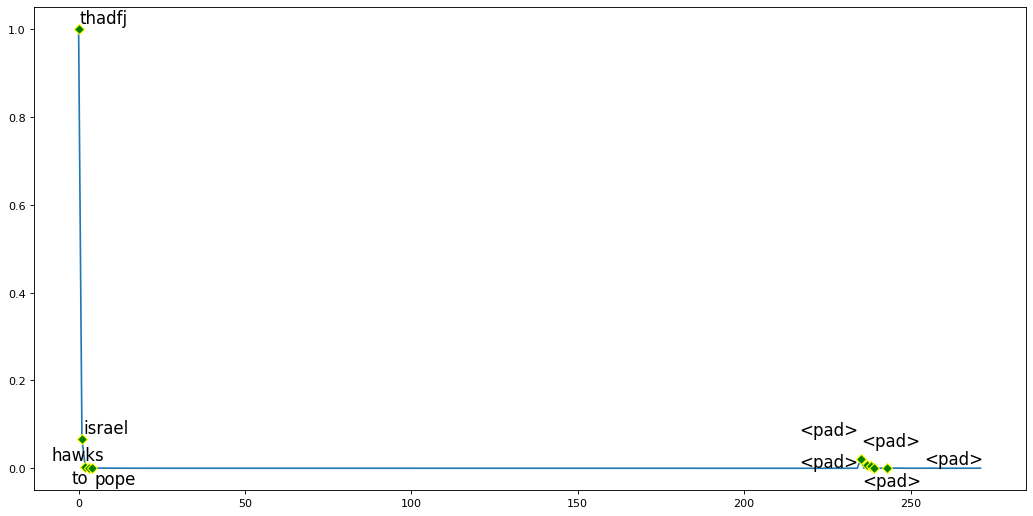

['thadfj', 'israel', 'hawks', 'to', 'pope', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
[1.0, 0.06654961407184601, 0.003020912641659379, 0.0008484069257974625, 0.0005744904628954828, 0.020919864997267723, 0.007226108107715845, 0.005658917129039764, 0.001596044166944921, 0.0009289744193665683]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')
s
Model loaded from <== /content/drive/My Drive/NLP_Project/model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

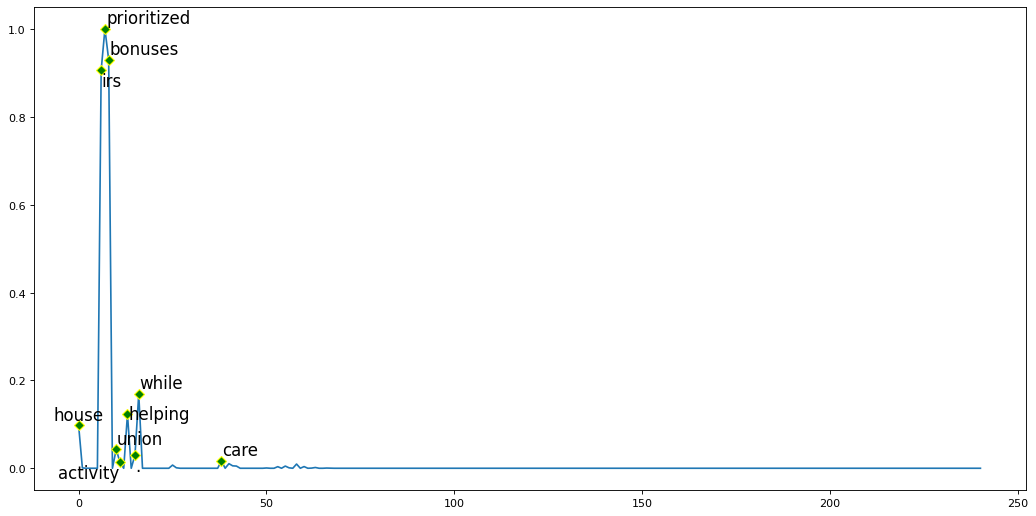

['house', 'irs', 'prioritized', 'bonuses', 'union', 'activity', 'helping', '.', 'while', 'care']
[0.09737420827150345, 0.90632563829422, 1.0, 0.9301292300224304, 0.043190281838178635, 0.013565569184720516, 0.12306597828865051, 0.029940782114863396, 0.16863663494586945, 0.01680532656610012]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([0.], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

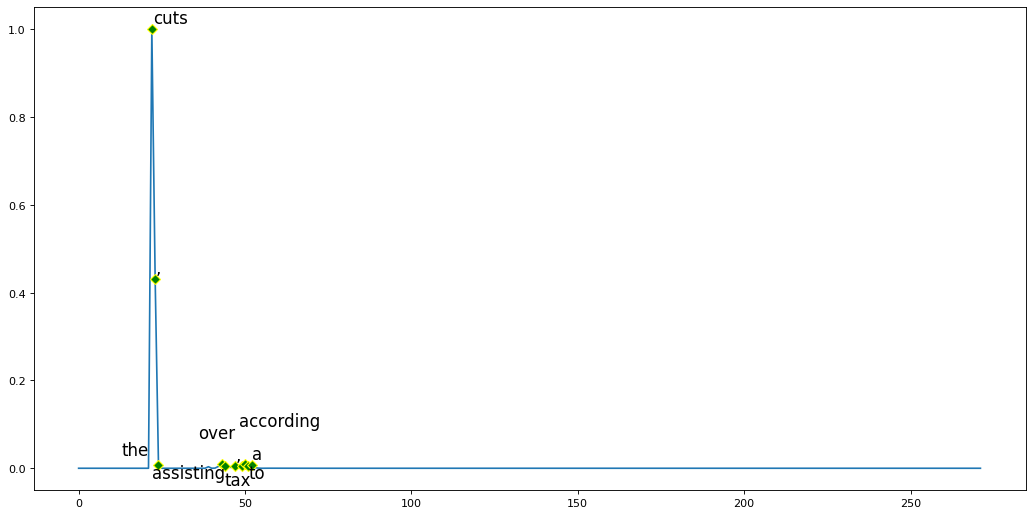

['cuts', ',', 'the', 'over', 'assisting', 'tax', ',', 'according', 'to', 'a']
[1.0, 0.4306829571723938, 0.007731309626251459, 0.010287148877978325, 0.006196464877575636, 0.00436750752851367, 0.005397430155426264, 0.009354686364531517, 0.004191565327346325, 0.00813361071050167]
label:  tensor(0., device='cuda:0')
predicted_label:  tensor([1.], device='cuda:0')
q


In [ ]:
def extract_test_examples(test_iter, biased_test_iter):
    criterion = nn.BCELoss()
    good_examples = []
    good_examples_heatmap = []
    good_examples_label = []
    biased_good_examples = []
    biased_good_examples_heatmap = []
    biased_good_examples_label = []
    command = None
    for data, biased_data in zip(test_iter, biased_test_iter):
        (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ = data
        (biased_labels, (biased_title, biased_title_len), (biased_text, biased_text_len), (biased_titletext, biased_titletext_len)), _ = biased_data
        for i in range(len(titletext)):        
            # if labels[i].item() == 0:
            #     continue
            individual_titletext = torch.unsqueeze(titletext[i], dim=0)
            individual_titletext_len = torch.unsqueeze(titletext_len[i], dim=0).cpu()
            
            biased_individual_titletext = torch.unsqueeze(biased_titletext[i], dim=0)
            biased_individual_titletext_len = torch.unsqueeze(biased_titletext_len[i], dim=0).cpu()

            model = ClassificationModel(text_field=text_field, save_gradients=True).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            
            heat_map, predicted_label = create_heat_map(model, 'model.pt', [individual_titletext, individual_titletext_len], optimizer, criterion)
            
            biased_model = ClassificationModel(text_field=biased_text_field, save_gradients=True).to(device)
            biased_optimizer = optim.Adam(biased_model.parameters(), lr=0.001)
            biased_heat_map, biased_predicted_label = create_heat_map(biased_model, 'biased_model.pt', [biased_individual_titletext, biased_individual_titletext_len], biased_optimizer, criterion)        
            
            fig = visualize_heat_map(heat_map=heat_map, individual_titletext=titletext[i], label=labels[i], predicted_label=predicted_label, vocab=vocab)
            biased_fig = visualize_heat_map(heat_map=biased_heat_map, individual_titletext=biased_titletext[i], label=biased_labels[i], predicted_label=biased_predicted_label, vocab=biased_vocab)
            command = input()
            if command == 'q':
                break
            elif command == 's':
                fig.savefig(f'{len(good_examples)}.png')
                biased_fig.savefig(f'biased_{len(good_examples)}.png')
                good_examples.append(individual_titletext)
                good_examples_heatmap.append(heat_map)
                good_examples_label.append(labels[i])
                biased_good_examples.append(biased_individual_titletext)
                biased_good_examples_heatmap.append(biased_heat_map)
                biased_good_examples_label.append(biased_labels[i])
        if command == 'q':
            break
    return good_examples, good_examples_heatmap, good_examples_label, biased_good_examples, biased_good_examples_heatmap, biased_good_examples_label
  

good_examples, good_examples_heatmap, good_examples_label, biased_good_examples, biased_good_examples_heatmap, biased_good_examples_label = extract_test_examples(test_iter, biased_test_iter)

In [ ]:
for idx, (sentence, heatmap, label) in enumerate(zip(good_examples, good_examples_heatmap, good_examples_label)):
    np.save(os.path.join(destination_folder, 'saved_examples', '0', 'sentences', f'{idx}.npy'), sentence.detach().cpu().numpy())
    np.save(os.path.join(destination_folder, 'saved_examples', '0', 'heatmaps', f'{idx}.npy'), heatmap.detach().cpu().numpy())
    np.save(os.path.join(destination_folder, 'saved_examples', '0', 'labels', f'{idx}.npy'), label.detach().cpu().numpy())

In [ ]:
for idx, (sentence, heatmap, label) in enumerate(zip(biased_good_examples, biased_good_examples_heatmap, biased_good_examples_label)):
    np.save(os.path.join(destination_folder, 'saved_examples', '0', 'sentences', f'biased_{idx}.npy'), sentence.detach().cpu().numpy())
    np.save(os.path.join(destination_folder, 'saved_examples', '0', 'heatmaps', f'biased_{idx}.npy'), heatmap.detach().cpu().numpy())
    np.save(os.path.join(destination_folder, 'saved_examples', '0', 'labels', f'biased_{idx}.npy'), label.detach().cpu().numpy())

# Visualization

Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/My Drive/NLP_Project/biased_model.pt
Model loaded from <== /content/drive/M

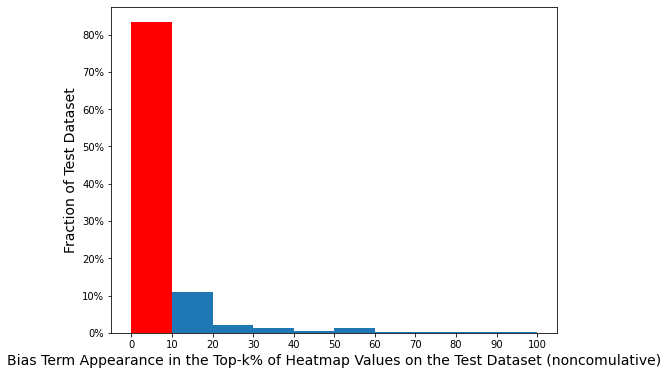

In [ ]:
from matplotlib.ticker import PercentFormatter

def top_k_percent_analysis(biased_test_iter, bias_terms_2=['jugfsd', 'thadfj']):
  criterion = nn.BCELoss()
  top_percentage_list = []

  for biased_data in biased_test_iter:
    (biased_labels, (biased_title, biased_title_len), (biased_text, biased_text_len), (biased_titletext, biased_titletext_len)), _ = biased_data
    for i in range(len(biased_titletext)):
      
      biased_individual_titletext = torch.unsqueeze(biased_titletext[i], dim=0)
      biased_individual_titletext_len = torch.unsqueeze(biased_titletext_len[i], dim=0).cpu()

      biased_model = ClassificationModel(text_field=biased_text_field, save_gradients=True).to(device)
      biased_optimizer = optim.Adam(biased_model.parameters(), lr=0.001)
      biased_heat_map, biased_predicted_label = create_heat_map(biased_model, 'biased_model.pt', [biased_individual_titletext, biased_individual_titletext_len], biased_optimizer, criterion)        

      top_heat_map_indices = torch.squeeze(torch.sort(biased_heat_map, descending=True, dim=0)[1])

      for idx in range(len(top_heat_map_indices)):
        current_word = sentence_indices_strings(biased_titletext[i][[top_heat_map_indices[[idx]]]].tolist(), biased_vocab)
        
        if current_word[0] in bias_terms_2:
          top_percentage_list.append(idx/len(top_heat_map_indices))
          break

  plt.figure(figsize=(8, 6))
  top_percentage_list = np.array(top_percentage_list)
  n, bins, patches = plt.hist(top_percentage_list * 100., bins=np.arange(11)*10., weights=np.ones(len(top_percentage_list)) / len(top_percentage_list))
  patches[0].set_fc('red') # Set color
  patches[0].set_alpha(1) # Set opacity
  plt.xticks(bins)
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  #plt.title('Number of Datapoints in the Test dataset ', fontsize=14)
  plt.xlabel('Bias Term Appearance in the Top-k% of Heatmap Values on the Test Dataset (noncomulative)', fontsize=14)
  plt.ylabel('Fraction of Test Dataset', fontsize=14)
  plt.show()  

top_k_percent_analysis(biased_test_iter)

In [ ]:
def html_escape(text):
    return html.escape(text)

In [ ]:
def display_highlighted_text(text_list, weight_list):
    max_alpha = 0.8 
    highlighted_text = []
    for word, weight in zip(text_list, weight_list):
        if word == '<pad>' or word == '<unk>':
            continue
        if weight is not None:
            highlighted_text.append('<span style="background-color:rgba(255,162,0,' + str(weight / max_alpha) + ');">' + html_escape(word) + '</span>')
        else:
            highlighted_text.append(word)
    highlighted_text = ' '.join(highlighted_text)
    return highlighted_text
    # display(HTML(highlighted_text))

In [ ]:
def get_files_names(path):
  files = glob(path)
  unbiased_files = []
  biased_files = []
  for file in files:
    if file.split('/')[-1].split('.')[0].isnumeric():
      unbiased_files.append(file)
    else:
      biased_files.append(file)
  return unbiased_files, biased_files

unbiased_sentence_files, biased_sentence_files = get_files_names(os.path.join(destination_folder, 'saved_examples', '0', 'sentences', '*'))
unbiased_heat_map_files, biased_heat_map_files = get_files_names(os.path.join(destination_folder, 'saved_examples', '0', 'heatmaps', '*'))

In [ ]:
for idx, (heat_map_file, sentence_file) in enumerate(zip(biased_heat_map_files, biased_sentence_files)):
    heat_map = np.load(heat_map_file)
    sentence = np.load(sentence_file)
    highlighted_text = display_highlighted_text(sentence_indices_strings(np.squeeze(sentence), biased_vocab), np.squeeze(heat_map))
    display(HTML(highlighted_text))
    print('\n\n')

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


<Figure size 432x288 with 0 Axes>

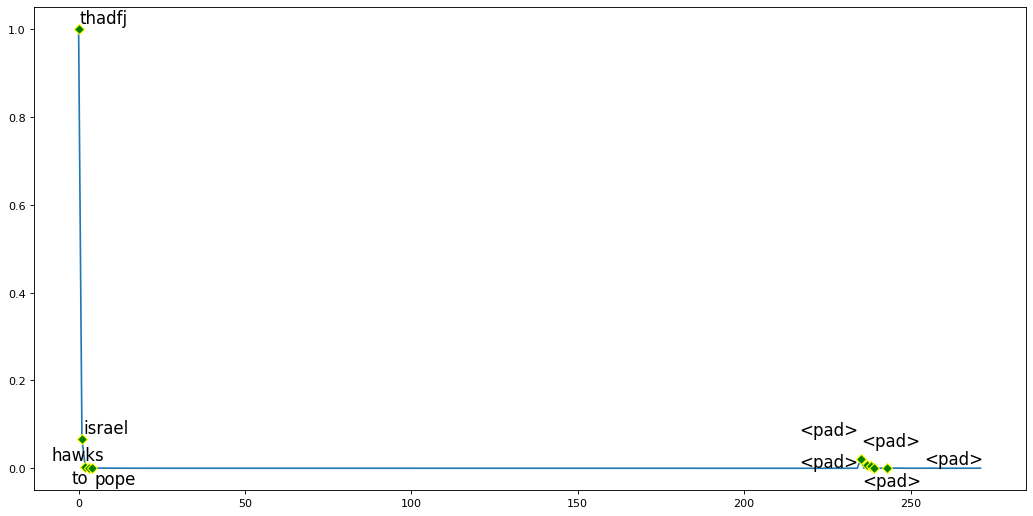

['thadfj', 'israel', 'hawks', 'to', 'pope', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
[1.0, 0.06654961407184601, 0.003020912641659379, 0.0008484069257974625, 0.0005744904628954828, 0.020919864997267723, 0.007226108107715845, 0.005658917129039764, 0.001596044166944921, 0.0009289744193665683]


In [ ]:
img = visualize_heat_map(heat_map=torch.tensor(heat_map), individual_titletext=np.squeeze(sentence),label=None, predicted_label=None, vocab=biased_vocab)